# Example of using litstudy

This notebook shows an example of how to use `litstudy` from inside a Jupyter notebook. It shows how to load a dataset, plot statistics, perform topic modeling, do network analysis, and some more advanced features. 

This notebook focuses on the topic of programming model for GPUs. GPUs (Graphic Processing Units) are specialized processors that are used in many data centers and supercomputers for data processing and machine learning. However, programming these devices remaining difficult, which is why there is a plethora of research on developing programming models for GPUs.

## Imports

In [1]:
# Import other libraries 
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbs

# Options for plots
plt.rcParams['figure.figsize'] = (10, 6)
sbs.set('paper')

# Import litstudy
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)

import litstudy

## Collecting the dataset

For this example, we have queried both IEEE Xplore and Springer Link for `"GPU" and "programming model"`. IEEE Xplore gives 5 CSV files (1 per page) and Springer Link gives a single CSV file. We load all files document sets and merge the resulting document sets.

In [2]:
# Load the CSV files
docs1 = litstudy.load_ieee_csv('data/ieee_1.csv')
docs2 = litstudy.load_ieee_csv('data/ieee_2.csv')
docs3 = litstudy.load_ieee_csv('data/ieee_3.csv')
docs4 = litstudy.load_ieee_csv('data/ieee_4.csv')
docs5 = litstudy.load_ieee_csv('data/ieee_5.csv')
docs_ieee = docs1 | docs2 | docs3 | docs4 | docs5
print(len(docs_ieee), 'papers loaded from IEEE')

docs_springer = litstudy.load_springer_csv('data/springer.csv')
print(len(docs_springer), 'papers loaded from Springer')

# Merge the two document sets
docs_csv = docs_ieee | docs_springer
print(len(docs_csv), 'papers loaded from CSV')

441 papers loaded from IEEE
1000 papers loaded from Springer
1441 papers loaded from CSV


We can also exclude some papers that we are not interested in. Here, we load a document set from a RIS file and subtract these documents from our original document set.

In [3]:
docs_exclude = litstudy.load_ris_file('data/exclude.ris')
docs_remaining = docs_csv - docs_exclude

print(len(docs_exclude), 'papers were excluded')
print(len(docs_remaining), 'paper remaining')

1 papers were excluded
1440 paper remaining


The amount metadata provided by the CSV files is minimal. To enhance the metadata, we can find the corresponding articles on Scopus using `refine_scopus`. This function returns two sets: the set of documents that were found on Scopus and the set of original documents not were not found. We have two options on how to handle these two sets: (1) merge the two sets back into one set or (2) discard the documents that were not found. We chose the second option here for simplicity.

In [4]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

docs_scopus, docs_notfound = litstudy.refine_scopus(docs_remaining)

print(len(docs_scopus), 'papers found on Scopus')
print(len(docs_notfound), 'papers were not found and were discarded')

100%|██████████| 1440/1440 [00:03<00:00, 361.20it/s]

1387 papers found on Scopus
53 papers were not found and were discarded


Next, we plot the number of documents per publication source.

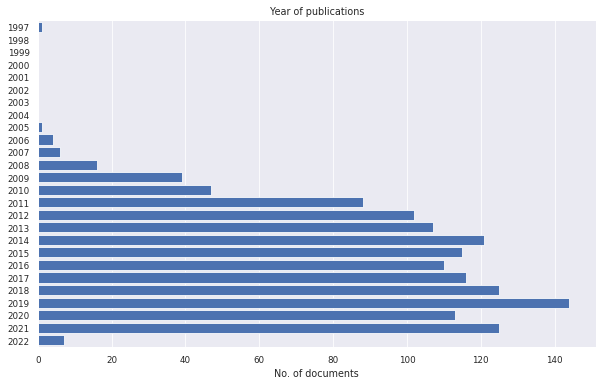

In [5]:
litstudy.plot_year_histogram(docs_scopus);

In this example, we discover that one document was published in 1997. This document should not be in our set since GPUs were not used for general purpose computing before 2006. We can remove this document by filtering on year of publication.

In [6]:
docs = docs_scopus.filter_docs(lambda d: d.publication_year >= 2000)

Print how many papers are left

In [7]:
print(len(docs), 'papers remaining')

1386 papers remaining


## General statistics

litstudy supports plot many general statistics of the document set as histograms. We show some simple examples below. 

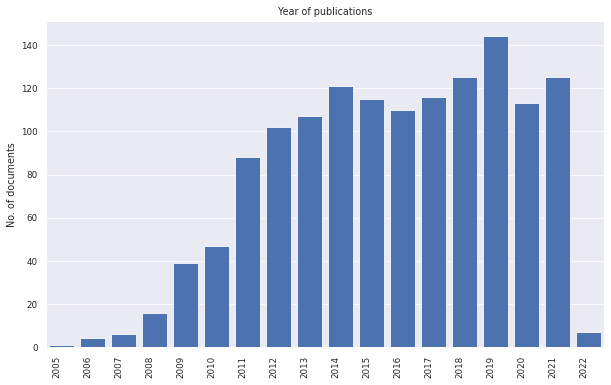

In [8]:
litstudy.plot_year_histogram(docs, vertical=True);

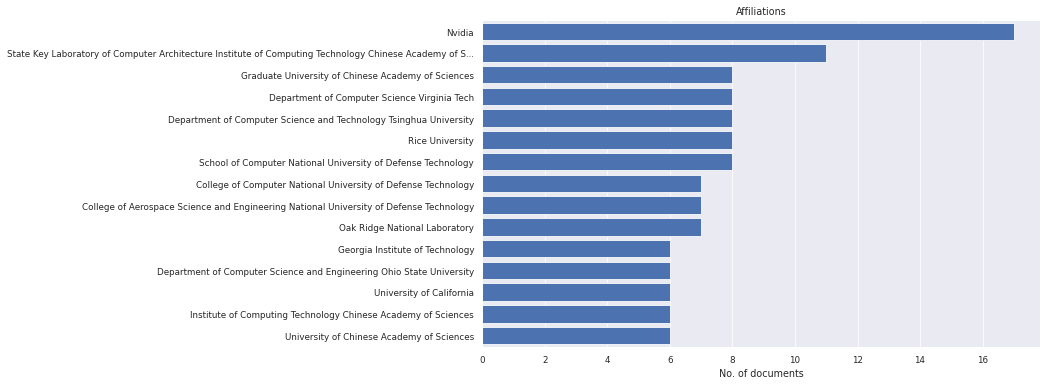

In [9]:
litstudy.plot_affiliation_histogram(docs, limit=15);

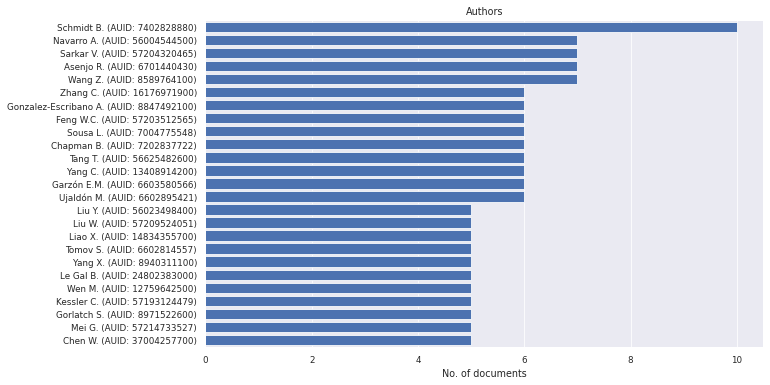

In [10]:
litstudy.plot_author_histogram(docs);

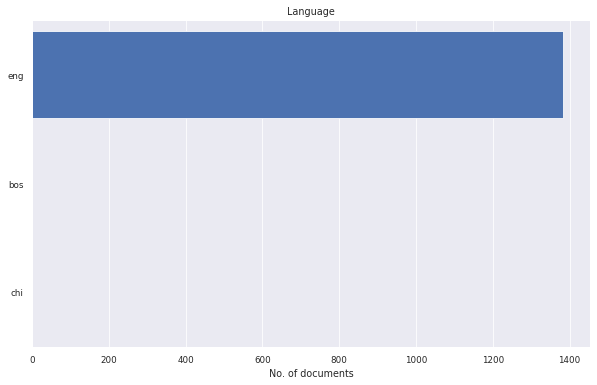

In [11]:
litstudy.plot_language_histogram(docs);

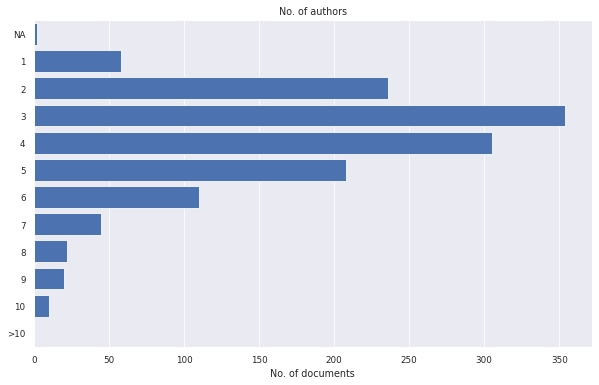

In [12]:
litstudy.plot_number_authors_histogram(docs);

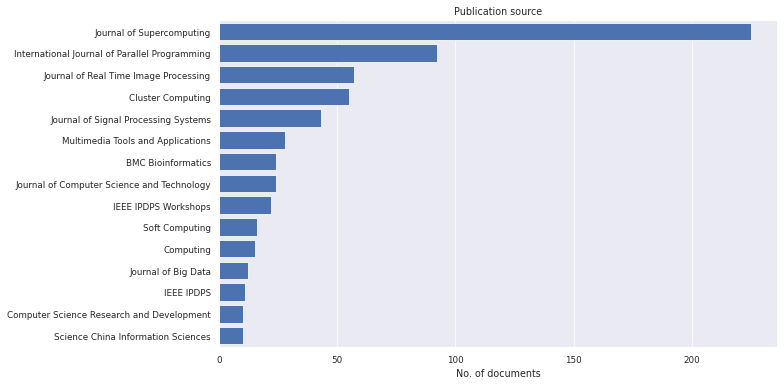

In [13]:
# This names are long, which is why a short abbreviation is provided.
mapping = {
    "IEEE International parallel and distributed processing symposium IPDPS": "IEEE IPDPS",
    "IEEE International parallel and distributed processing symposium workshops IPDPSW": "IEEE IPDPS Workshops",
}

litstudy.plot_source_histogram(docs, mapper=mapping, limit=15);

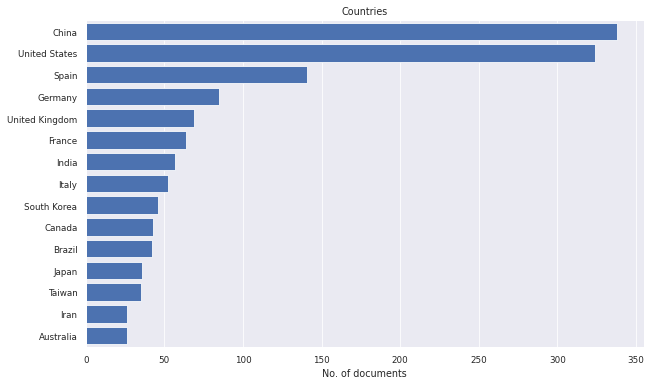

In [14]:
litstudy.plot_country_histogram(docs, limit=15);

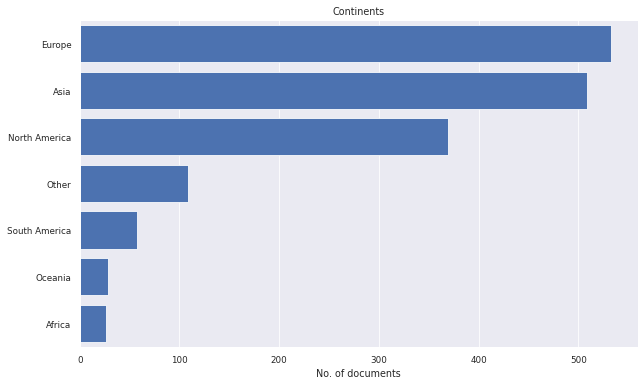

In [15]:
litstudy.plot_continent_histogram(docs);

## Network analysis

The network below shows an example of a co-citation network. 
This is a type of network where nodes represent documents and edges represent pairs of documents that have been cited together simulatenously by other papers. The strength of the edges indicates how often two documents have been cited together.
Two papers with a high co-citation strength (i.e., stronger edge) are usually highly related. 

In [16]:
litstudy.plot_cocitation_network(docs, max_edges=500)

100%|██████████| 1000/1000 [00:00<00:00, 1752.38it/s]

BarnesHut Approximation  took  0.14  seconds
Repulsion forces  took  0.32  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


## Topic modeling

litstudy supports automatic topic discovery based on the words used in documents abstracts. We show an example below. First, we need to build a corpus from the document set. Note that `build_corpus` supports many arguments to tweak the preprocessing stage of building the corpus. In this example, we pass `ngram_threshold=0.85`. This argument adds commonly used n-grams (i.e., frequent consecutive words) to the corpus. For instance, `artificial` and `intelligence` is a bigram, so a token `artificial_intelligence` is added to the corpus.

In [17]:
corpus = litstudy.build_corpus(docs, ngram_threshold=0.8)

We can compute a word distribution using `litstudy.compute_word_distribution` which shows how often each word occurs across all documents. In this example, we focus only on n-grams by selecting tokens that contain a `_`. We see that words such as `artificial intelligence` and `trade offs` indeed have been recognized as common bigrams.

In [18]:
litstudy.compute_word_distribution(corpus).filter(like='_', axis=0).sort_index()

,count
artificial_intelligence,13
author_exclusive,41
berlin_heidelberg,83
chinese_academy,6
coarse_grained,16
...,...
synthetic_aperture,7
trade_offs,10
unified_device,108
xeon_phi,21


Let's visualize the word distribution from this corpus.

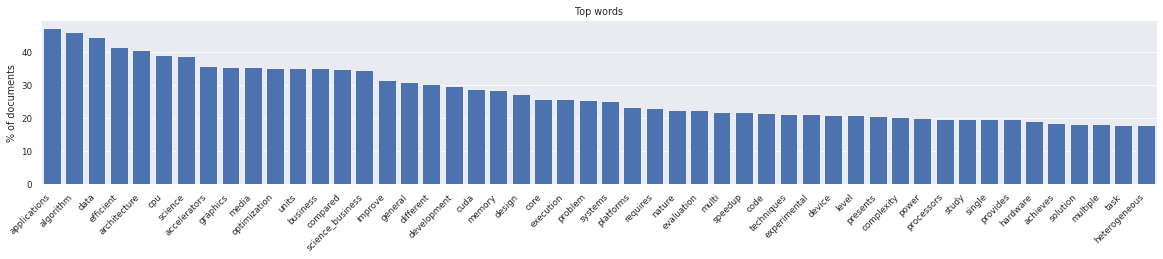

In [19]:
plt.figure(figsize=(20, 3))
litstudy.plot_word_distribution(corpus, limit=50, title="Top words", vertical=True, label_rotation=45);

This word distribution looks normal. Next, we train an NMF topic model. Topic modeling is a technique from natural language processing for discovering abstract "topics" in a set of document. We need to manually select the number of desired topics. Here we choose 15 topics. It is recommended to experiment with more or less topics to obtain topics that are more fine-grained or more coarse-grained

In [20]:
num_topics = 15
topic_model = litstudy.train_nmf_model(corpus, num_topics, max_iter=250)

To understand the result of NMF, we can print the top 3 words for each topic.

In [21]:
for i in range(num_topics):
    print(f'Topic {i+1}:', topic_model.best_tokens_for_topic(i))

Topic 1: ['cluster', 'mpi', 'node', 'hybrid', 'communication']
Topic 2: ['mapreduce', 'big', 'data', 'hadoop', 'cloud']
Topic 3: ['simulation', 'particle', 'numerical', 'fluid', 'flow']
Topic 4: ['learning', 'network', 'deep', 'deep_learning', 'training']
Topic 5: ['fpga', 'memory', 'access', 'cache', 'bandwidth']
Topic 6: ['openacc', 'compiler', 'openmp', 'directive', 'language']
Topic 7: ['image', 'segmentation', 'algorithm', 'medical', 'sensing']
Topic 8: ['sequence', 'alignment', 'protein', 'database', 'search']
Topic 9: ['video', 'decoding', 'encoding', 'ldpc', 'motion']
Topic 10: ['gpgpu', 'cuda', 'code', 'general_purpose', 'general']
Topic 11: ['energy', 'heterogeneous', 'power', 'consumption', 'systems']
Topic 12: ['graph', 'vertex', 'framework', 'analytics', 'edge']
Topic 13: ['scheduling', 'task', 'heterogeneous', 'resources', 'execution']
Topic 14: ['intel', 'matrix', 'phi', 'xeon', 'cloud']
Topic 15: ['opencl', 'portability', 'benchmark', 'platforms', 'sycl']


An alternative way to visualize the output of NMF is to plot each discovered topic as a word cloud. The size of each word in a cloud indicate the importance of that word for that topic.

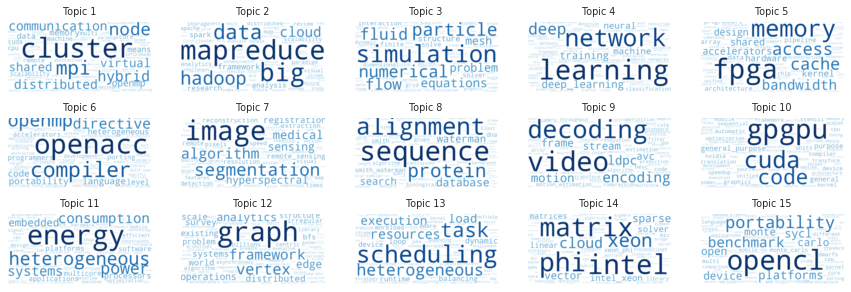

In [22]:
plt.figure(figsize=(15, 5))
litstudy.plot_topic_clouds(topic_model, ncols=5);

These 15 topics look promising. For example, there is one topic on graphs, one on OpenACC (the open accelerators programming standard), one on OpenCL (the open compute language), one on FPGAs (field-programmable gate array), etc. 

We can visualize the results as a "landscape" plot. This is a visual appealing way to place documents on 2D plane. The documents are placed such that similar documents are located closed to each other. However, this is a non-linear embedding so the distances between the documents are not linear.

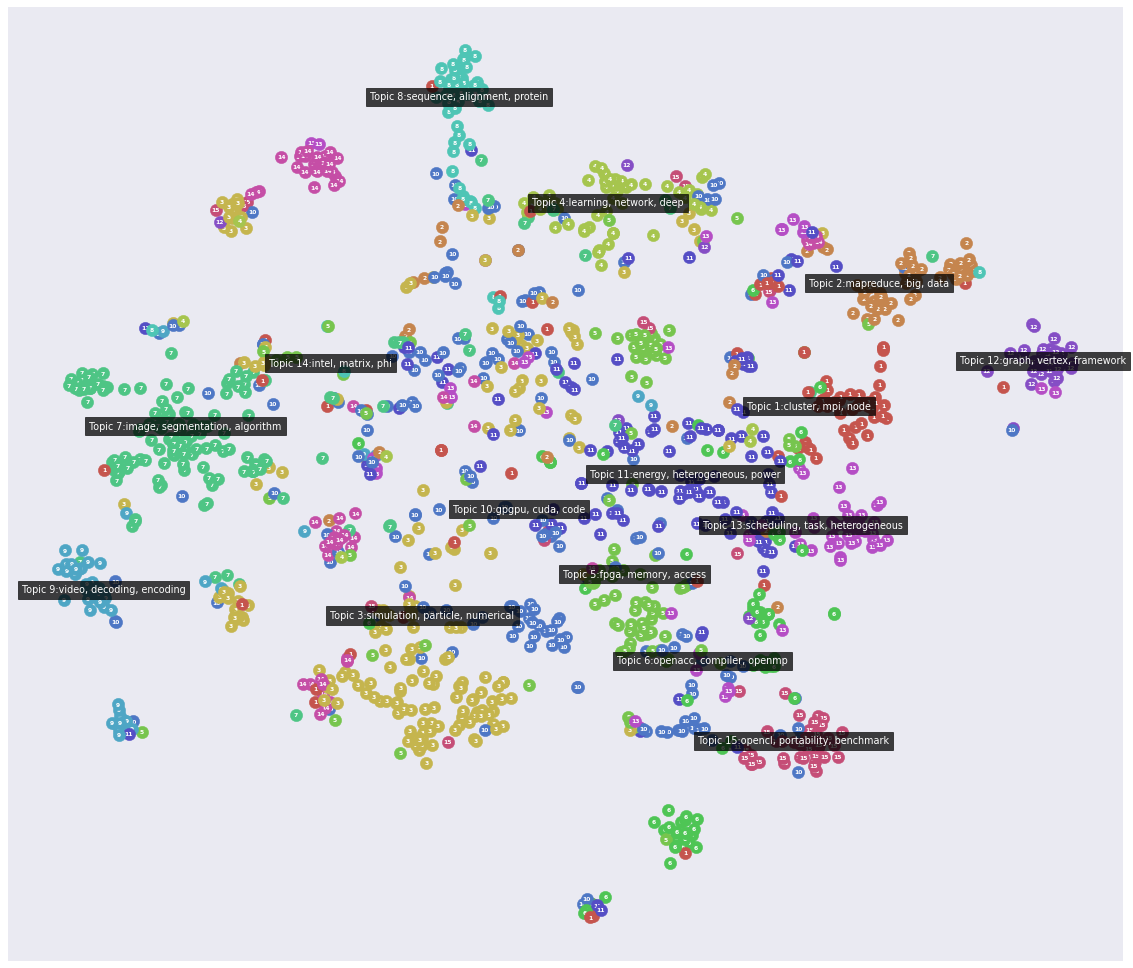

In [23]:
plt.figure(figsize=(20, 20))
litstudy.plot_embedding(corpus, topic_model);

## Advanced topic modeling

We can combine the results of topic modeling with the plotting of statistics. Here we show we a simple example.

One of the topics appears to be on "deep_learning". First, we find the topic id for the topic that most strongly belongs to "deep_learning". 

In [24]:
topic_id = topic_model.best_topic_for_token('deep_learning')

Let's print the top 10 papers that most stongly belong to this topic to check the results. We see that these are indeed documents on the topic of deep learning.

In [25]:
for doc_id in topic_model.best_documents_for_topic(topic_id, limit=10):
    print(docs[int(doc_id)].title)

High performance networked computing in media, services and information management
What do Programmers Discuss about Deep Learning Frameworks
Sparse evolutionary deep learning with over one million artificial neurons on commodity hardware
Deep learning for intelligent traffic sensing and prediction: recent advances and future challenges
SOLAR: Services-oriented learning architectures: Deep learning as a service
Reveal training performance mystery between TensorFlow and PyTorch in the single GPU environment
Network Management 2030: Operations and Control of Network 2030 Services
SOLAR: Services-Oriented Deep Learning Architectures-Deep Learning as a Service
DLPlib: A Library for Deep Learning Processor
Machine Learning and Deep Learning frameworks and libraries for large-scale data mining: a survey


Next, we annotate the document set with a "dl_topic" tag for document that strongly belong to this topic (i.e., weight above a certain threshold).

After this, we define two groups: documents that have the tag "dl_topic" and documents that do not have this tag. Now we can, for instance, print the publications over the years to see if interest in deep learning has increased or decreased over the years.

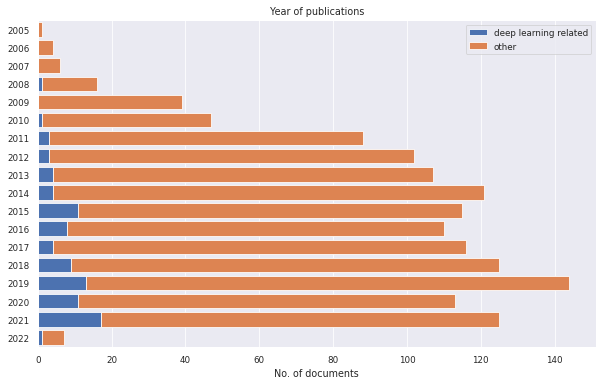

In [26]:
threshold = 0.2
dl_topic = topic_model.doc2topic[:, topic_id] > threshold

docs = docs.add_property('dl_topic', dl_topic)


groups = {
    'deep learning related': 'dl_topic',
    'other': 'not dl_topic', 
}

litstudy.plot_year_histogram(docs, groups=groups, stacked=True);

The histogram shows that interest in deep learning has clearly risen over the years. We can even calculate the exact amount by calculating the percentage of documents on deep learning each year. The example below shows that this percentage has increased from just 3.4% in 2011 to 13.6% in 2021.

In [27]:
table = litstudy.compute_year_histogram(docs, groups=groups)
table.div(table.sum(axis=1), axis=0) * 100

,deep learning related,other
2005,0.000000,100.000000
2006,0.000000,100.000000
2007,0.000000,100.000000
2008,6.250000,93.750000
2009,0.000000,100.000000
2010,2.127660,97.872340
2011,3.409091,96.590909
2012,2.941176,97.058824
2013,3.738318,96.261682
2014,3.305785,96.694215


Alternatively, we can plot the two groups for the publications source. We can see that some journals/conferences have a strong focus on deep learning (e.g. "Neural Computing and Applications"), while others have no or few publications on deep learning (e.g. "Journal of Real Time Image Processing").

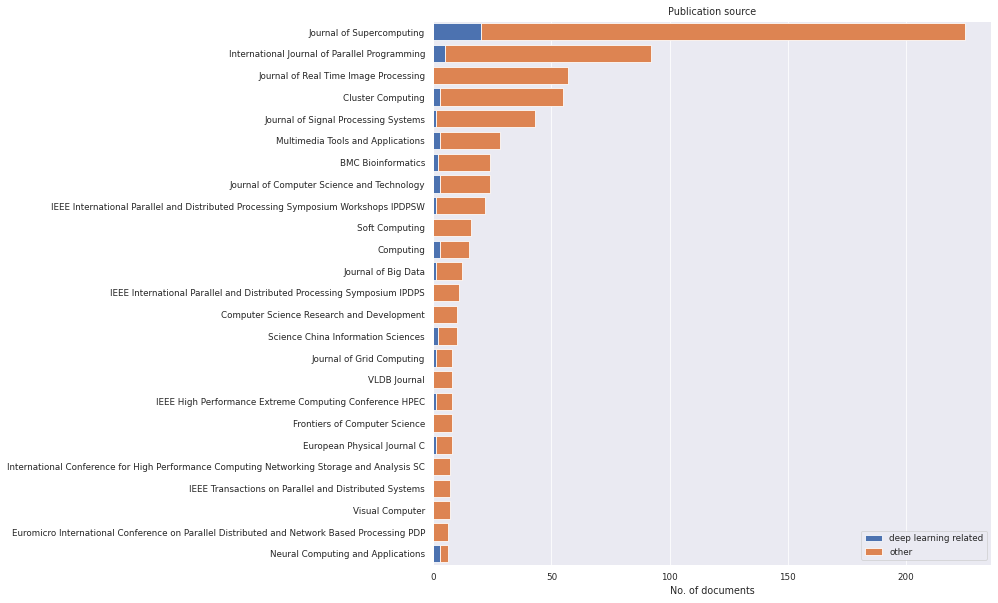

In [28]:
plt.figure(figsize=(10, 10))
litstudy.plot_source_histogram(docs, groups=groups, limit=25, stacked=True);

We can even calculate the most popular publication venues for deep learning in our dataset using some simple Panda functions. It appears that "Neural Computing and Applications" is the most popular publication venue.

In [29]:
# Compute histogram by publication venue
table = litstudy.compute_source_histogram(docs, groups=groups)

# Add column 'total'
table['total'] = table['deep learning related'] + table['other']

# Remove rare venues that have less than 5 publications
table = table[table['total'] >= 5]

# Add column 'ratio'
table['ratio'] = table['deep learning related'] / table['total'] * 100

# Sort by ratio in descending order
table.sort_values(by='ratio', ascending=False)

,deep learning related,other,total,ratio
Neural Computing and Applications,3,3,6,50.000000
Computing,3,12,15,20.000000
IEEE International Symposium on Workload Characterization IISWC,1,4,5,20.000000
Science China Information Sciences,2,8,10,20.000000
IEEE High Performance Extreme Computing Conference HPEC,1,7,8,12.500000
European Physical Journal C,1,7,8,12.500000
Journal of Grid Computing,1,7,8,12.500000
Journal of Computer Science and Technology,3,21,24,12.500000
Multimedia Tools and Applications,3,25,28,10.714286
Journal of Supercomputing,20,205,225,8.888889
